In [1]:
import numpy as np
import pandas as pd
import math

In [117]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler

In [3]:
# subset_col=['year','diqu','jigou_1','jigou_2', 'jigou_3', 'guanzhi','chushen_1','pinji_numeric', 'xitong']
df=pd.read_csv('../data/Jinshenlu.txt',sep='\t',
#                usecols=subset_col, 
              error_bad_lines=False)
# df.sample(frac=0.01).to_csv('../data/Jinshenlu_sample.csv', encoding='utf-8')

e:\hkust\learning\fyp\venv_fyt\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,25,27,29,30,31,32,33,35,36,37,43,44,45,46,47,48,49,50,51,54,55,56,57,58,60,63,66,68,71,73,74,84,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Curate the database: filter out the malformed for the moment.
1. Calculate the portion of malformed and some basic stats
2. remove malformed and irrelevant(fangkeben_only=0 qiren=0 exclude people without names)

Count how much are machu civilians

In [13]:
def convt(s):
    f=None
    try:
        f=float(s)
    except:
        pass
    return f
print((df['qiren']=='旗人').sum()/df.shape[0])
print((df['fangkeben_only']==1).sum()/df.shape[0])
print((df['xuhao'].apply(convt)>=20000).sum()/df.shape[0])

0.21570111636069703
0.04625493778798516
0.09660182127684154


In [7]:
print('no surname',df['xing'].isnull().sum())
print('no last name', df['ming'].isnull().sum())
print('no zihao', df['zihao'].isnull().sum())
print('no name at all', (df['xing'].isnull() & df['ming'].isnull() & df[ 'zihao'].isnull()).sum())

no surname 782335
no last name 194191
no zihao 2727832
no name at all 193626


Now remove all the irrelevant/malformed
xuhao >20k discarded

In [14]:
irr_idx=df[(df['qiren']=='旗人')|(df['fangkeben_only']==1) |
           (df['xing'].isnull() & df['ming'].isnull() & df[ 'zihao'].isnull())].index.tolist()
malformed_idx=df[(df['year'].isin(['銀庫', '蒙古',7.0])) | 
                 (df['pinji_numeric']=='州') | df['year'].isnull() |
                df['qiren'].isnull() | (df['xuhao']=='麗')].index.tolist()
to_remove=set(irr_idx)|set(malformed_idx)

In [15]:
print(len(to_remove))

918912


In [16]:
df.drop(to_remove, inplace=True)
df['year']=df['year'].astype(float)
df['pinji_numeric']=df['pinji_numeric'].astype(float)
df['xuhao']=df['xuhao'].astype(int)

In [23]:
print('pinji_detailed_numeric is more complete:',df['pinjin_detailed_numeric'].notnull().sum())
print('pinji_numeric has missing values', df['pinji_numeric'].notnull().sum())

2058889

1760739

## Up to this point every record has "year" and "品级"（not pinji_numeric）

Weird: 1880-1882 no records?

Text(0,0.5,'#Records')

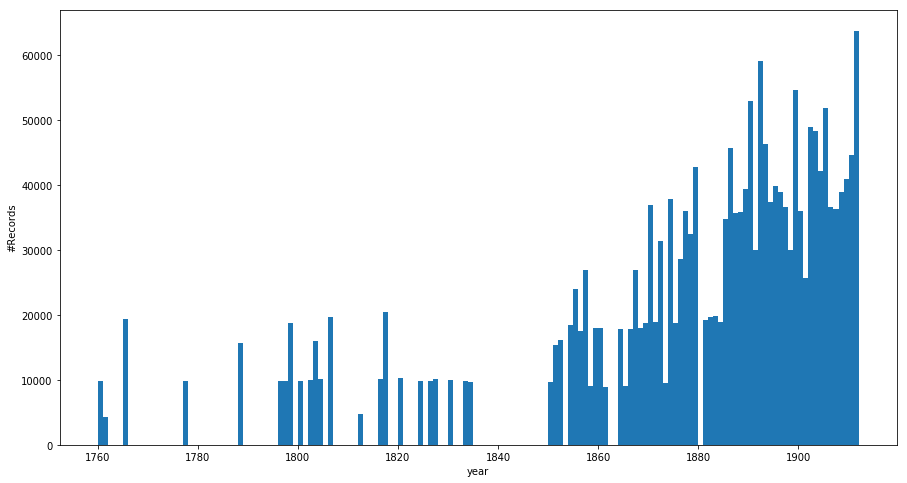

In [17]:
plt.figure(figsize=(15,8))
counts_ends=plt.hist(df['year'].dropna(), bins=np.arange(1760,1913))
plt.xlabel('year')
plt.ylabel('#Records')

Is that the real distribution of Qing civil servant's rankings?

Text(0,0.5,'#records')

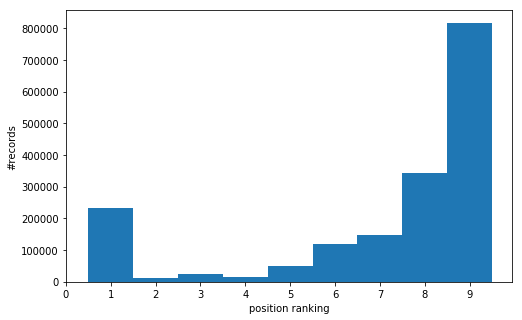

In [18]:
plt.figure(figsize=(8,5))
plt.hist(df['pinji_numeric'].dropna().astype(float), bins=9, align='right')
plt.xticks(np.arange(10))
plt.xlabel('position ranking')
plt.ylabel('#records')

## 13% records have unmatched rankings

In [20]:
def str2float(s):
    if s in [np.nan, '不入流', '未入流']:
        return 10.0
    if s=='從一品(應為正四品)':
        return 4.0
    dic=dict(zip(['一', '二','三','四','五', '六','七','八','九'], np.arange(1,10)))
    base = dic[s[-2]]
    base+=0.5*('從' in s)
    return float(base)
for i in df['pinji_detailed'].unique():
    print(i, 'converted into', str2float(i))

nan converted into 10.0
正八品 converted into 8.0
正七品 converted into 7.0
從九品 converted into 9.5
正六品 converted into 6.0
從五品 converted into 5.5
正五品 converted into 5.0
從七品 converted into 7.5
未入流 converted into 10.0
從六品 converted into 6.5
正二品 converted into 2.0
從四品 converted into 4.5
正九品 converted into 9.0
從三品 converted into 3.5
從一品 converted into 1.5
正四品 converted into 4.0
正三品 converted into 3.0
八品 converted into 8.0
正一品 converted into 1.0
從二品 converted into 2.5
從八品 converted into 8.5
從一品(應為正四品) converted into 4.0
三品 converted into 3.0
九品 converted into 9.0
四品 converted into 4.0
不入流 converted into 10.0
六品 converted into 6.0
一品 converted into 1.0
二品 converted into 2.0
七品 converted into 7.0
五品 converted into 5.0


In [21]:
df['pinji_detailed_numeric']=df['pinji_detailed'].apply(str2float)

In [23]:
unmatch_count=0

for (orig, gen) in df[['pinji_numeric', 'pinji_detailed_numeric']].values:
    if math.isnan(orig):
        continue
    else:
        unmatch_count+=int(orig)!=int(gen)
print(unmatch_count)

253959


Draw the diff distribution

In [25]:
diffs=[]
for (orig, gen) in df[['pinji_numeric', 'pinji_detailed_numeric']].values:
    if math.isnan(orig):
        continue
    else:
        if orig==0:
            orig=10
        diffs.append(gen - orig)

(array([1.124068e+06, 6.146500e+05, 0.000000e+00, 0.000000e+00,
        3.750000e+02, 0.000000e+00, 4.853000e+03, 0.000000e+00,
        9.963000e+03, 0.000000e+00, 2.315000e+03, 0.000000e+00,
        1.003000e+03, 0.000000e+00, 6.840000e+02, 0.000000e+00,
        2.687000e+03, 0.000000e+00, 1.410000e+02, 0.000000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 20 Patch objects>)

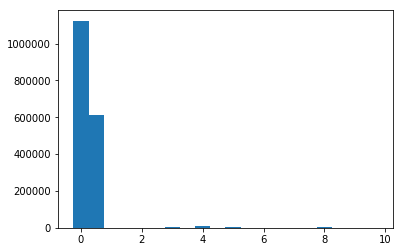

In [26]:
plt.hist(diffs, bins=np.arange(0,10.5,0.5), align='left')

In [27]:
pd.DataFrame(data=diffs).apply(lambda x: x> 0.6).sum()

0    22021
dtype: int64

### So there are 1% incorrect pinji_numeric

In [28]:
df['jicheng_hao'].unique()

array([1.0, 2.0, 3.0, nan, 4.0, 5.0, 6, 7, '3', '4', '2', '5', '6', '7'],
      dtype=object)

In [29]:
print(len(df['unique_id'].unique()))
print(df.shape)

256819
(2058889, 98)


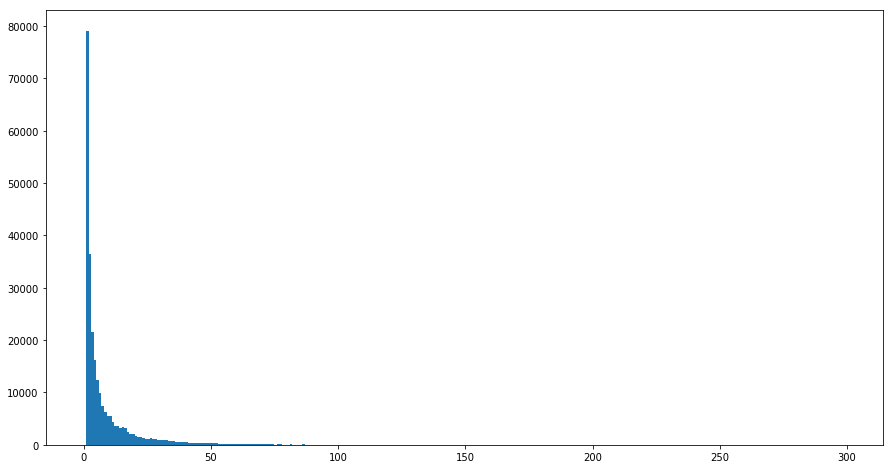

In [30]:
plt.figure(figsize=(15,8))
_=plt.hist(df['unique_id'].value_counts(), bins=np.arange(0,300))

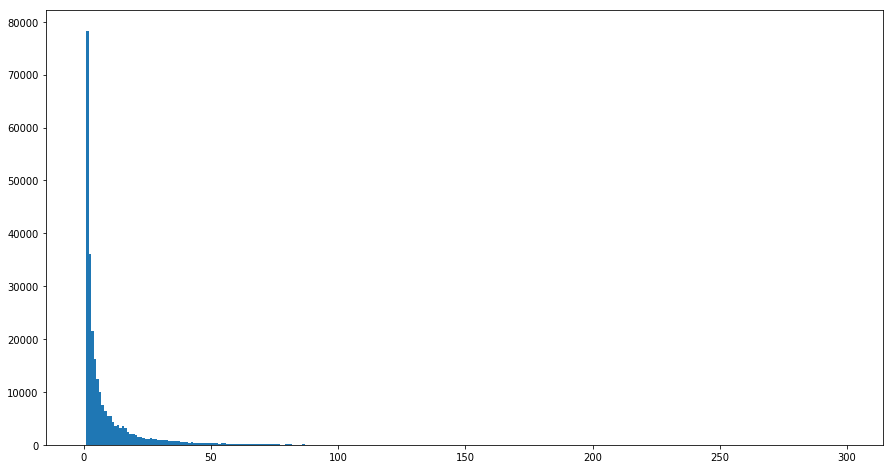

In [31]:
plt.figure(figsize=(15,8))
_=plt.hist(df[['unique_id', 'linked_record_count']].drop_duplicates()['linked_record_count'].dropna(), bins=np.arange(0,300))
# plt.hist(df['linked_record_count'].dropna(), )

Examine rankings in detail

In [78]:
min_arr=[]
for id_, subtable in tqdm(df[['unique_id','pinji_detailed_numeric']].groupby('unique_id')):
#     if subtable['pinjin_detailed_numeric'].isnull().all():
#         continue
    key=subtable['pinji_detailed_numeric'].max()
    arr=subtable['pinji_detailed_numeric'].dropna().values
    min_arr.append((key, arr))
sorted_min_arr=sorted(min_arr, key=lambda x:x[0])

In [79]:
points=[]
colors=[]
for i, (start,rankings) in tqdm(enumerate(sorted_min_arr)):
    for ranking in rankings:
        points.append([ranking, i])
        colors.append(start)
#     for itp in np.arange(rankings.min(), rankings.max(), 0.2):
#         points.append([itp, i])
points=np.array(points)

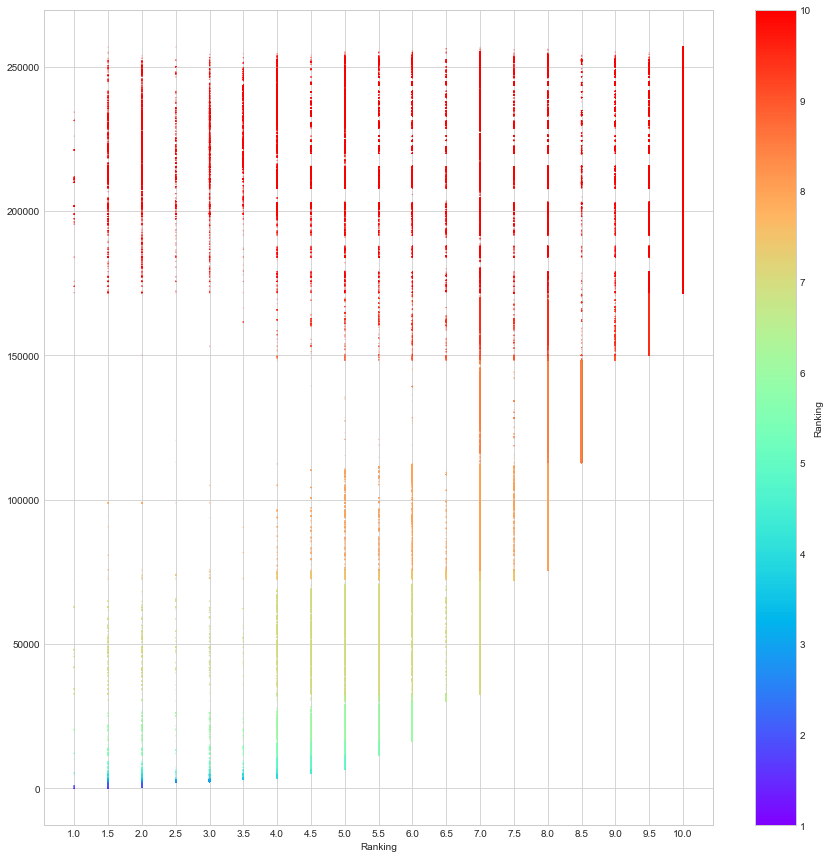

In [80]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,15))
plt.scatter(points[:,0],points[:,1],s=0.01, c=colors, cmap='rainbow')
plt.colorbar(label='Ranking')
plt.xlabel('Ranking')
_=plt.xticks(np.arange(1, 10.1,0.5))

In [14]:
count=0
for id_, subtable in tqdm(df[['unique_id','pinji_detailed_numeric']].groupby('unique_id')):
    if subtable['pinji_detailed_numeric'].notnull().any():
        count+=1
    else:
        print(id_)


In [15]:
print(count)
print(df['unique_id'].unique().shape[0])
print(count/df['unique_id'].unique().shape[0])

256818
256819
0.9999961062070952


Text(0,0.5,'#People')

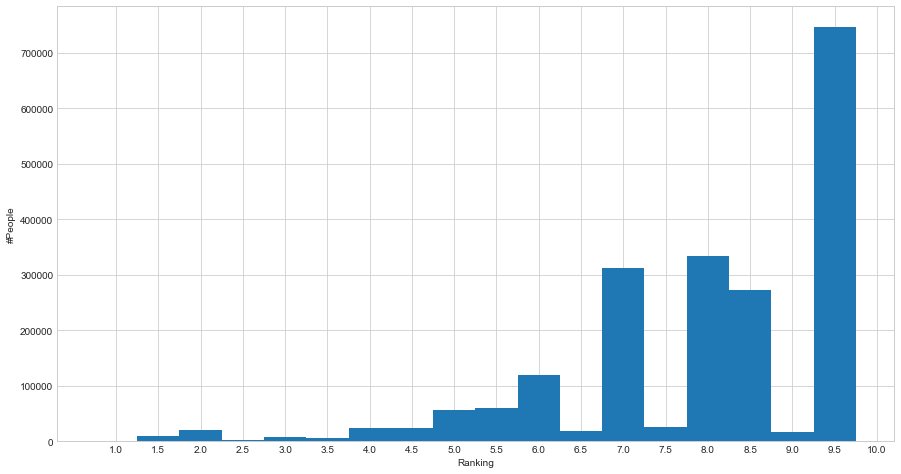

In [50]:
plt.figure(figsize=(15, 8))
plt.hist(df['pinjin_detailed_numeric'], align='left', bins=np.arange(1,10.4,0.5))
plt.xticks(np.arange(1,10.4,0.5))
plt.xlabel("Ranking")
plt.ylabel('#People')

## make heatmap

In [33]:
tmp=df[['unique_id','pinji_detailed_numeric']].groupby('unique_id').agg([np.min, np.max]).reset_index()

In [58]:
mat=tmp.pinji_detailed_numeric.groupby(['amin', 'amax']).agg(len).reset_index().rename(index=str,columns={0:'count'})

In [69]:
tem=pd.DataFrame(data=np.zeros((19,19)), index=np.arange(1.0, 10.5, 0.5), columns=np.arange(10.0, 0.5, -0.5))
for idx in tem.index:
    for col in tem.columns:
        if col<=idx:
            continue
        row=mat[(mat['amax']==col) & (mat['amin']==idx)]
        if row.shape[0]>0:
            tem[col][idx] = row['count'][0]
tem

,10.0,9.5,9.0,8.5,8.0,7.5,7.0,6.5,6.0,5.5,5.0,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0
1.0,19.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0
1.5,643.0,0.0,0.0,0.0,7.0,3.0,129.0,2.0,24.0,31.0,23.0,14.0,18.0,12.0,24.0,16.0,213.0,0.0,0.0
2.0,643.0,1.0,0.0,0.0,0.0,7.0,49.0,3.0,20.0,17.0,17.0,20.0,37.0,19.0,50.0,34.0,0.0,0.0,0.0
2.5,55.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,9.0,0.0,0.0,0.0,0.0
3.0,643.0,1.0,0.0,0.0,4.0,4.0,63.0,1.0,35.0,21.0,25.0,29.0,63.0,18.0,0.0,0.0,0.0,0.0,0.0
3.5,680.0,2.0,0.0,0.0,2.0,1.0,14.0,0.0,10.0,9.0,6.0,9.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,743.0,11.0,4.0,0.0,19.0,27.0,258.0,9.0,145.0,81.0,99.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.5,288.0,16.0,1.0,1.0,40.0,43.0,602.0,7.0,364.0,227.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1160.0,31.0,14.0,7.0,128.0,169.0,848.0,62.0,564.0,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.5,407.0,40.0,5.0,2.0,99.0,103.0,1361.0,109.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(87,0.5,'highest career ranking')

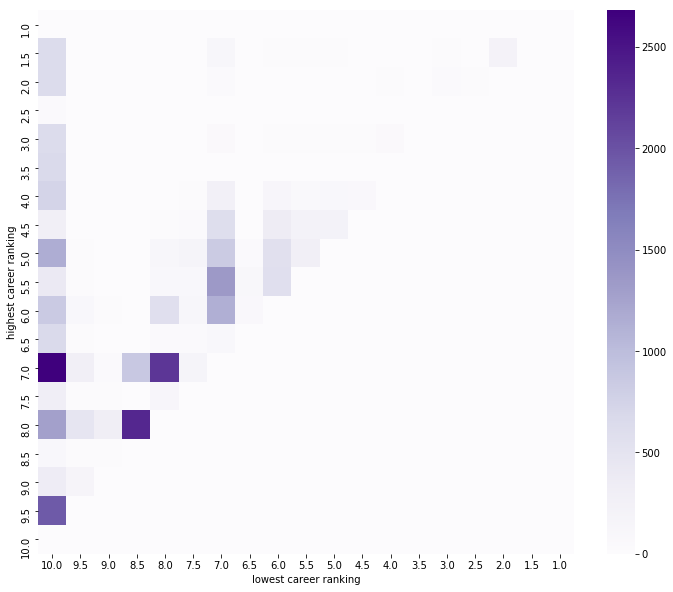

In [76]:
plt.figure(figsize=(12,10))
import seaborn as sns
sns.heatmap(tem, cmap='Purples')
ax=plt.gca()
ax.set_xlabel('lowest career ranking')
ax.set_ylabel('highest career ranking')

In [ ]:
1. the position components of the heated places

## Examine promotion speed of locality/position

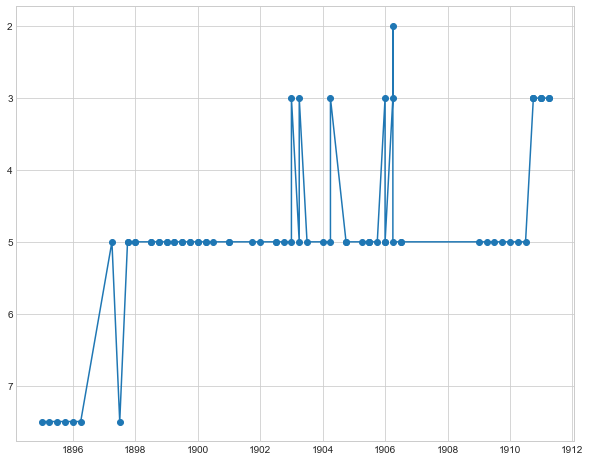

In [109]:
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
ps=df[df['unique_id']==189420028200.0][['unique_id','pinji_detailed_numeric', 'diqu',
                                     'jigou_1','jigou_2', 'guanzhi', 'quanxuan_year',
                                     'ganzhi_year_1','year', 'assigned_edition']]
plt.plot(ps['year'], ps['pinji_detailed_numeric'], 'o-')

In [108]:
ps # exclude after 1905, no houbu when duplicated in one edition, exclude people appearing only once

,unique_id,pinji_detailed_numeric,diqu,jigou_1,jigou_2,guanzhi,quanxuan_year,ganzhi_year_1,year,assigned_edition
2442432,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.00,光绪21春.xlsx
2442433,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.25,光绪21夏.xlsx
2442434,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.50,光绪21秋.xlsx
2442435,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1895.75,光绪21冬.xlsx
2442436,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1896.00,光绪22春.xlsx
2442437,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1896.25,光绪22夏爵秩全览.xlsx
2442438,1.894200e+11,5.0,京師,刑部衙門,額外司員,郎中,NaN,NaN,1897.25,光緒23夏.xlsx
2442439,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1897.50,光緒23秋 縉紳全書.xlsx
2442440,1.894200e+11,5.0,京師,刑部衙門,額外司員,郎中,NaN,NaN,1897.75,光緒23冬.xlsx
2442441,1.894200e+11,5.0,京師,軍機處,漢二班,刑部候補郎中,NaN,NaN,1897.75,光緒23冬.xlsx




0. how to determine years? otherwise, we don't have any info about their promotion speed, given that 'year' variable cannot be trusted
1. completeness:1) before 1850 cannot be used correct. 2) after 1850, are all people tracked? for each person, is his records complete?
2. duplicate records: the same info duplicated by two 刻本 from different 书局？

now can only model each person by rankings. Features:
1. min, max, occurences, intervals 

In [113]:
def ave_interval(v):
    s=np.array(sorted(v))
    if s.shape[0]==1:
        return 0
    else:
        return (s[1:]-s[:-1]).mean()

In [137]:
fea_df=df[['unique_id','pinji_detailed_numeric']].groupby('unique_id').agg([min, max, len, ave_interval]).reset_index().sample(1000)

In [ ]:
fea_mat=StandardScaler().fit_transform(fea_df['pinji_detailed_numeric'])
from sklearn.manifold import TSNE
projs=TSNE().fit_transform(fea_mat)

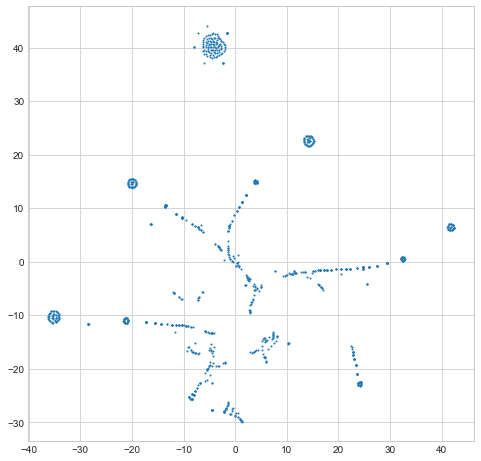

In [142]:
plt.figure(figsize=(8,8))
plt.plot(projs[:,0], projs[:,1], 'o', ms=1)

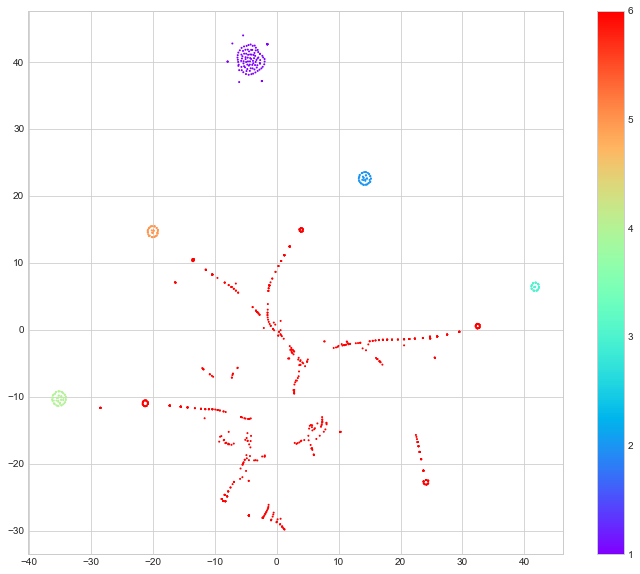

In [154]:
def label(x, y):
    if y>30:
        return 1
    if y>20:
        return 2
    if x>40:
        return 3
    if x<-30:
        return 4
    if x<-15 and y>10:
        return 5
    return 6

fea_df['x']=projs[:, 0]
fea_df['y']=projs[:, 1]
fea_df['label']=fea_df[['x', 'y']].apply(lambda x: label(*x), axis=1)
plt.figure(figsize=(12,10))
plt.scatter(projs[:,0], projs[:,1], s=np.full(fea_df.shape[0], 1), c=fea_df['label'], cmap='rainbow')
plt.colorbar()

In [153]:
fea_df[['label','pinji_detailed_numeric', 'x', 'y']].groupby('label').agg(np.mean)

pinji_detailed_numeric                                             x  \
                         min        max        len ave_interval              
label                                                                        
1                  10.000000  10.000000   1.000000     0.000000  -4.123290   
2                   8.000000   8.000000   1.000000     0.000000  14.230603   
3                  10.000000  10.000000   2.000000     0.000000  41.760834   
4                   7.000000   7.000000   1.000000     0.000000 -35.173294   
5                   8.500000   8.500000   1.000000     0.000000 -20.015985   
6                   7.683333   8.126389  11.026389     0.099871   2.979302   

               y  
                  
label             
1      40.432789  
2      22.585371  
3       6.424525  
4     -10.276068  
5      14.651818  
6      -7.743281

In [152]:
fea_df[['label','pinji_detailed_numeric']]

label pinji_detailed_numeric                         
                                min   max   len ave_interval
171235     6                   10.0  10.0  14.0     0.000000
27184      6                    9.5   9.5   1.0     0.000000
191153     6                    7.0   7.0   9.0     0.000000
37626      6                    2.0  10.0   2.0     8.000000
128698     6                    4.5   4.5   1.0     0.000000
160475     6                    6.0   6.0  13.0     0.000000
214418     6                    9.5   9.5  14.0     0.000000
155691     6                   10.0  10.0  15.0     0.000000
7253       5                    8.5   8.5   1.0     0.000000
100584     6                   10.0  10.0  18.0     0.000000
118969     6                   10.0  10.0   6.0     0.000000
89599      2                    8.0   8.0   1.0     0.000000
184609     6                    2.0  10.0  28.0     0.296296
112762     6                    8.0   8.0  12.0     0.000000
214140     6                    6.0   6.0   6.0     0.000000
175016     6                   10.0  10.0  13.0     0.000000
98728      6                    1.5   7.5  48.0     0.127660
163839     6                    5.0   5.0   4.0     0.000000
40204      1                   10.0  10.0   1.0     0.000000
122866     6                    7.0   7.0  13.0     0.000000
173389     6                    2.0  10.0  82.0     0.098765
209191     6                    7.0   7.0   4.0     0.000000
102527     6                   10.0  10.0   3.0     0.000000
186521     2                    8.0   8.0   1.0     0.000000
185636     6                    7.0   7.0   7.0     0.000000
176814     6                    8.5   8.5  16.0     0.000000
166733     1                   10.0  10.0   1.0     0.000000
172095     6                   10.0  10.0   3.0     0.000000
155099     6                    7.0   7.0   7.0     0.000000
211948     6                    8.0   8.0  43.0     0.000000
...      ...                    ...   ...   ...          ...
218323     6                   10.0  10.0  10.0     0.000000
1184       2                    8.0   8.0   1.0     0.000000
248873     6                   10.0  10.0   3.0     0.000000
104342     6                    8.0   8.0  10.0     0.000000
872        6                    9.0  10.0   4.0     0.333333
249622     6                    8.0   8.0   4.0     0.000000
184935     4                    7.0   7.0   1.0     0.000000
147912     6                    8.5   8.5   7.0     0.000000
68307      6                    6.0   6.0   1.0     0.000000
48294      6                    9.0   9.0   1.0     0.000000
69900      5                    8.5   8.5   1.0     0.000000
214087     6                    5.0   5.0   6.0     0.000000
28196      6                    5.5   5.5   1.0     0.000000
40279      1                   10.0  10.0   1.0     0.000000
137025     6                    8.0   8.0   8.0     0.000000
47809      6                    4.5  10.0  14.0     0.423077
70019      6                    7.0   7.0   2.0     0.000000
78168      5                    8.5   8.5   1.0     0.000000
177261     2                    8.0   8.0   1.0     0.000000
214046     6                    2.0  10.0  32.0     0.258065
21497      6                    6.0   6.0   2.0     0.000000
1100       6                    7.0   7.0   2.0     0.000000
75736      6                   10.0  10.0   4.0     0.000000
59347      4                    7.0   7.0   1.0     0.000000
217963     6                    8.0   8.5  59.0     0.008621
142285     6                    9.5   9.5  13.0     0.000000
211619     5                    8.5   8.5   1.0     0.000000
202429     6                   10.0  10.0   4.0     0.000000
41601      1                   10.0  10.0   1.0     0.000000
43130      6                    8.5   8.5  11.0     0.000000

[1000 rows x 5 columns]

In [146]:
fea_df.groupby('label').agg(len)

unique_id pinji_detailed_numeric                           x    y
                                   min  max  len ave_interval          
label                                                                  
1           111                    111  111  111          111  111  111
2            45                     45   45   45           45   45   45
3            34                     34   34   34           34   34   34
4            49                     49   49   49           49   49   49
5            41                     41   41   41           41   41   41
6           720                    720  720  720          720  720  720

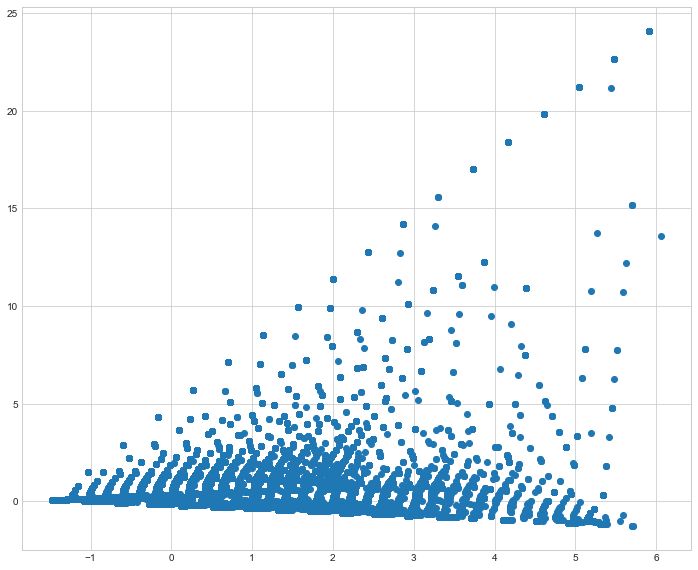

In [123]:
plt.figure(figsize=(12,10))
from sklearn.decomposition import PCA
projs=PCA(n_components=2).fit_transform(fea_mat)
plt.plot(projs[:,0], projs[:,1], 'o')

plan: 
1. (province level + ranking) -> speed
2. position -> speed
3. ...